Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
epoch=0, loss=1.2355
epoch=100, loss=0.0128
epoch=200, loss=0.0090
epoch=300, loss=0.0001
epoch=400, loss=0.0002
epoch=500, loss=0.0002
epoch=600, loss=0.0218
epoch=700, loss=0.0003
epoch=800, loss=0.0000
epoch=900, loss=0.0000


Text(0.5, 1.0, '1-step ahead prediction based on 10 previous data')

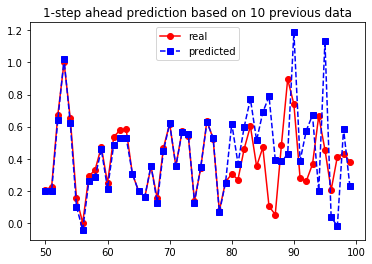

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
# 그래프 리셋
tf.reset_default_graph() 
# 재현성을 위해 시드 지정
tf.set_random_seed(0)
#--------------------------------------------------
# 길이가 100인 data(#AR(2) with a1=0.5; a2=-0.3) 만들기
#--------------------------------------------------
k=100
x=np.random.normal(0,1,k); 
e=np.random.normal(0,1,k)
a1=0.5 
a2=-0.3

x[2]=a1*x[1]+a2*x[0]+e[2]
for i in range(2,k):
    x[i]=a1*x[i-1]+a2*x[i-2]+e[i]
    
# 표준화    
x=(x-min(x))/(max(x)-min(x))
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 16
# 미니배치 크기: 1
# 반복 수: 1000
# 학습률 :0.0005
# 서열길이 10
hidden_size =16 
learning_rate = 0.0005 
nepochs = 1000 
seq_len=10 
batch_size=1

#------------------------------------------
# 시계열 훈련에 적합한 데이터 만들기
# 0~9 : input, 10: target
# 1~10 : input, 11: target
# ...
# 89~98 : input, 99: target
#-------------------------------------------
dataX = []; dataY = []
for i in range(k-seq_len):
    tempX=x[i:i+seq_len]
    dataX.append(tempX)
    tempY=x[i+seq_len]
    dataY.append(tempY)
# 훈련자료 크기    
sample_size=np.array(dataY).shape[0]
 
# 플레이스 홀더
X = tf.placeholder(tf.float32, shape=[None,seq_len,1])  
Y = tf.placeholder(tf.float32, [None,1])

# 가중치와 편의 변수 
W = tf.Variable(tf.random_normal([hidden_size, 1]))
b = tf.Variable(tf.random_normal([1]))

# LSTM 셀 정의 
cell1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
cell2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
# 은닉층 2개
multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
output0, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)  

# 서열의 마지막 출력 값
output1 = tf.transpose(output0, [1, 0, 2]); 
outputs = output1[-1]   
Y_pred= tf.matmul(outputs, W) + b

# 손실함수와 옵티마이저
cost = tf.reduce_sum(tf.square(Y_pred - Y))  
optim = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session()
sess.run(tf.global_variables_initializer())
# 마지막 20개를 제외하여 훈련 
for epoch in range(nepochs):
    for i in range(sample_size-20):
        x=dataX[i].reshape(1,seq_len,1)
        y=dataY[i].reshape(1,1)
        loss, state = sess.run([cost, optim], feed_dict={X :x , Y:y})  
        if epoch % 100 == 0 and i == 0:
            print("epoch={}, loss={:.4f}" .format(epoch, loss))

# 훈련에 사용되지 않은 20개와 사용된 30개에 대한 예측          
prediction=[]      
for i in range(sample_size-50,sample_size):
    x=dataX[i].reshape(1,seq_len,1)
    y=dataY[i].reshape(1,1)
    pred = sess.run(Y_pred, feed_dict={X :x , Y:y}) 
    prediction.append(pred)

# 예측 결과 그림
b=np.array(prediction).shape[0]  

plt.plot(range(50,50+b),dataY[sample_size-50:sample_size],'ro-', label='real')
plt.plot(range(50, 50+b),np.array(prediction).reshape(b,),'bs--', label='predicted')
plt.legend(loc='best')
plt.title('1-step ahead prediction based on 10 previous data')